# Online Joint State and Parameter Estimation for AR SSM  $\mathbf{A}$
State space model
\begin{align*}
    &\mathbf{x}_t = \mathbf{A}\mathbf{x}_{t-1} + \mathbf{p}_t \quad \mathbf{p}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t + m_t \quad v_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_t\,|\,\mathbf{x}_{t-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_t\;\middle|\; \mathbf{A}\mathbf{x}_{t-1},  \gamma_y^{-1} \right)\\
    &p(y_t\,|\,\mathbf{x}_{t}) = \mathcal{N}\left(y_t \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_t, \epsilon \right)
\end{align*}

where
\begin{align*}
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

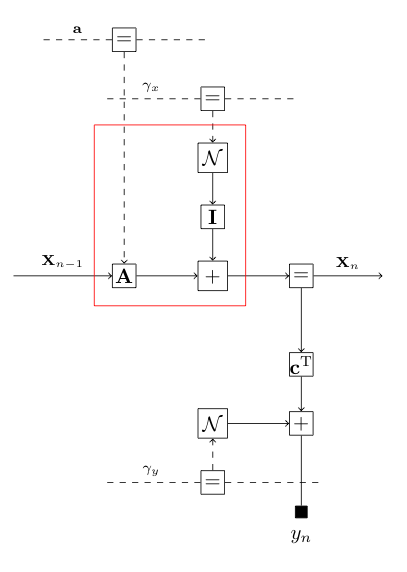

In [1]:
using Images
img = load("../ffgs/HAR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$ and states $\mathbf{x}_n$, while setting noises' precision $\gamma_x=1$, $\gamma_y=2$.

In [262]:
using ProgressMeter
using Revise
using ForneyLab
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [303]:
ARorder = 10 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# AR data
a_w = 0.0001; b_w = 0.0001
process_noise = b_w/a_w
coefs, x = generate_data(1000, ARorder, 1, noise_variance=process_noise)
#x = use_data("../data/daily-minimum-temperatures.csv", 10)
# Observations
measurement_noise = 2.0
y = [xi[1] + sqrt(measurement_noise)*randn() for xi in x[ARorder:end]]

991-element Array{Float64,1}:
  1.1982359110475853 
 -0.9315394412335732 
  1.3030390722957033 
  0.1510346116499786 
 -0.06945383172372693
 -4.191340956530759  
 -5.137835584545915  
  0.4180402639563563 
  0.4296477976615787 
 -1.420588871010653  
 -0.41379962517612046
  4.963024754495711  
  2.734951018911248  
  ⋮                  
 -0.6143523030442147 
 -0.103438429568739  
  0.4938611813318564 
  0.7496902350239412 
  1.5107593407517002 
  4.164050799379469  
 -0.37830343607044714
 -5.994356013919749  
  1.3034959121616014 
 -2.402246733253748  
 -0.08154862226167081
 -2.8488807466494936 

In [304]:
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a_t
@RV w_a_t
@RV m_y_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w, b_w)
@RV x_t = AR(a, x_t_prev, w)
c = zeros(ARorder); c[1] = 1.0
@RV y_t ~ GaussianMeanPrecision(m_y_t, measurement_noise^-1)
DotProduct(y_t, c, x_t)

# Placeholders for prior
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_y_t, :m_y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 15497918521365795801 -->
 
 15497918521365795801 
 
 dot 
 dotproduct_1 
 
<!-- 17864129569124862739 -->
 
 17864129569124862739 
 
 clamp_4 
 
<!-- 15497918521365795801--17864129569124862739 -->
 
 15497918521365795801--17864129569124862739 
 
 clamp_4 
 1 out 
 2 in1 
 
<!-- 6129760673731665672 -->
 
 6129760673731665672 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 15497918521365795801--6129760673731665672 -->
 
 15497918521365795801--6129760673731665672 
 
 y_t 
 1 out 
 1 out 
 
<!-- 5125852328847953432 -->
 
 5125852328847953432 
 
 Autoregression 
 autoregression_1 
 
<!-- 15497918521365795801--5125852328847953432 -->
 
 15497918521365795801--5125852328847953432 
 
 x_t 
 1 out 
 3 in2 
 
<!-- 2589907212281185557 -->
 
 2589907212281185557 
 
 placeholder_m_x_t_prev 
 
<!-- 16459779976076916488 -->
 
 16459779976076916488 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 2589907212281185557--16459779976076916488 -->
 
 2589907212281185557--16459779976076916488 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 1554730455349434460 -->
 
 1554730455349434460 
 
 clamp_2 
 
<!-- 14368158525032388191 -->
 
 14368158525032388191 
 
 Gam 
 gamma_1 
 
<!-- 14368158525032388191--1554730455349434460 -->
 
 14368158525032388191--1554730455349434460 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 18158235383365411795 -->
 
 18158235383365411795 
 
 clamp_1 
 
<!-- 14368158525032388191--18158235383365411795 -->
 
 14368158525032388191--18158235383365411795 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 16750769624089956274 -->
 
 16750769624089956274 
 
 placeholder_w_x_t_prev 
 
<!-- 16750769624089956274--16459779976076916488 -->
 
 16750769624089956274--16459779976076916488 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 8237436295984128051 -->
 
 8237436295984128051 
 
 clamp_3 
 
<!-- 6129760673731665672--8237436295984128051 -->
 
 6129760673731665672--8237436295984128051 
 
 clamp_3 
 1 out 
 3 w 
 
<!-- 10494900801070293502 -->
 
 10494900801070293502 
 
 placeholder_m_y_t 
 
<!-- 10494900801070293502--6129760673731665672 -->
 
 10494900801070293502--6129760673731665672 
 
 m_y_t 
 2 m 
 1 out 
 
<!-- 5125852328847953432--14368158525032388191 -->
 
 5125852328847953432--14368158525032388191 
 
 w 
 1 out 
 4 W 
 
<!-- 5125852328847953432--16459779976076916488 -->
 
 5125852328847953432--16459779976076916488 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 5284387429471657167 -->
 
 5284387429471657167 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 5125852328847953432--5284387429471657167 -->
 
 5125852328847953432--5284387429471657167 
 
 a 
 1 out 
 3 a 
 
<!-- 1474478864683558093 -->
 
 1474478864683558093 
 
 placeholder_m_a_t 
 
<!-- 1474478864683558093--5284387429471657167 -->
 
 1474478864683558093--5284387429471657167 
 
 m_a_t 
 2 m 
 1 out 
 
<!-- 15744849097764260027 -->
 
 15744849097764260027 
 
 placeholder_w_a_t 
 
<!-- 15744849097764260027--5284387429471657167 -->
 
 15744849097764260027--5284387429471657167 
 
 w_a_t 
 3 w 
 1 out

In [305]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, ids=[:A :X_t])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepX_t! (generic function with 3 methods)

In [306]:
# Define values for prior statistics
m_a_0 = zeros(ARorder)
w_a_0 = (0.0001*diagAR(ARorder))
#fnobs = #[xi .+ sqrt(measurement_noise)*randn() for xi in x[1:ARorder]] # first p(p=ARorder) obsevations
m_x_prev_0 = zeros(ARorder)
w_x_prev_0 = (0.5*diagAR(ARorder))

# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(y))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_a = Vector{Vector{Float64}}(undef, length(y))
w_a = Vector{Array{Float64, 2}}(undef, length(y))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [307]:
marginals = Dict()
# VMP iterations
n_its = 10

# Storage for estimations
means = []
precisions = []
real = [x[1] for x in x[ARorder:end]]
# Storage for MSE of test set
WMSEs = []
p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w, b=b_w)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_t_min, w_a_t_min

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :m_a_t => m_a_t_min,
                    :w_a_t => w_a_t_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min)
        
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x_prev[t] = unsafeMean(marginals[:x_t])
        w_x_prev[t] = unsafePrecision(marginals[:x_t])
        m_a_t_min = m_a[t]
        w_a_t_min = w_a[t]
        m_x_t_prev_min = m_x_prev[t]
        w_x_t_prev_min = w_x_prev[t]
    end
    push!(means, m_x_prev[t][1])
    push!(precisions, w_x_prev[t][1])
    push!(WMSEs, wmse(real[1:t], means, 1 ./ precisions))
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:02


In [308]:
from = 1
estimated = [x[1] for x in m_x_prev[from:end]]
real = [x[1] for x in x[ARorder:end]]
noise = [y[1] for y in y[from:end]]

println("Δ(estimated, real)=", mse(estimated, real))
println("Δ(estimated, noise)=", mse(estimated, noise))
println("Δ(noise, actual)=", mse(noise, real))

Δ(estimated, real)=1.3319843059882648
Δ(estimated, noise)=2.100700609326444
Δ(noise, actual)=1.9826957845644015


In [309]:
mean(marginals[:a])

10-element Array{Float64,1}:
  0.026790896715216804
 -0.2094660299717942  
 -0.08099341460614554 
  0.21998670103351667 
  0.08606242250738783 
 -0.043053660347915426
 -0.2216389842691331  
 -0.02597034906491543 
  0.21047775807548508 
 -0.00570764917243588 

In [318]:
scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
toshow = 10 # number of points to plot at once

anim = @animate for i in 1:length(estimated)-toshow
    s = plot(xticks = i:div(toshow, 2):i+toshow);
    ylims!(minimum(noise) - .1, maximum(noise) + .1);
    scatter!(collect(i:i+toshow), noise[i:i+toshow], label="noisy observations", 
            markershape = :xcross, markeralpha = 0.6,
            markersize = 2)
    
    plot!(collect(i:i+toshow), [estimated[i:i+toshow], estimated[i:i+toshow]], fillrange=[estimated[i:i+toshow] -
          scale .* sqrt.(v_x[i:i+toshow]), estimated[i:i+toshow] + scale .* sqrt.(v_x[i:i+toshow])],
          linestyle=:dash, linewidth = 2,
          color=:black,
          fillalpha = 0.2,
          fillcolor = :black,
          label="inferred")
    
    plot!(collect(i:i+toshow), real[i:i+toshow], color = :magenta, linewidth = 1.0, label="real state")
end

Animation("/var/folders/jn/1xv7kskx42v_97gx1xd8y_g40000gq/T/tmpg0Bckx", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000972.png", "000973.png", "000974.png", "000975.png", "000976.png", "000977.png", "000978.png", "000979.png", "000980.png", "000981.png"])

In [319]:
gif(anim, "../gifs/KMPstate.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/KMPstate.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/KMPstate.gif")

In [320]:
# Plotting MSE
anim = @animate for i in 1:length(WMSEs)
    s = plot()
    ylims!(minimum(WMSEs) - 1, maximum(WMSEs) + 1)
    xlims!(1, length(WMSEs))
    plot!(collect(1:i), WMSEs[1:i], xlabel="observation", ylabel="WMSE", label="")
end;

In [321]:
gif(anim, "../gifs/MSE_evo_state.gif", fps = 100)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo_state.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo_state.gif")

# Random walk model 
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

We set $\gamma_y = 1.0$ and $\gamma_y = 2.0$

In [310]:
rwg = FactorGraph()

# declare priors as random variables
@RV m_x_t_min
@RV w_x_t_min
@RV x_t_min ~ GaussianMeanPrecision(m_x_t_min, w_x_t_min)

@RV n_t ~ GaussianMeanPrecision(0.0, 1.0)
@RV x_t = x_t_min + n_t
@RV m_t ~ GaussianMeanPrecision(0.0, 2.0^-1)
@RV y_t = x_t + m_t

# Placeholders for prior
placeholder(m_x_t_min, :m_x_t_min)
placeholder(w_x_t_min, :w_x_t_min)

# Placeholder for data
placeholder(y_t, :y_t)
ForneyLab.draw(rwg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 14931505269261781685 -->
 
 14931505269261781685 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 182889431170640399 -->
 
 182889431170640399 
 
 clamp_2 
 
<!-- 6025858686780415251 -->
 
 6025858686780415251 
 
 placeholder_m_x_t_min 
 
<!-- 6025858686780415251--14931505269261781685 -->
 
 6025858686780415251--14931505269261781685 
 
 m_x_t_min 
 2 m 
 1 out 
 
<!-- 1886307827737700650 -->
 
 1886307827737700650 
 
 placeholder_w_x_t_min 
 
<!-- 1886307827737700650--14931505269261781685 -->
 
 1886307827737700650--14931505269261781685 
 
 w_x_t_min 
 3 w 
 1 out 
 
<!-- 2288984836054647588 -->
 
 2288984836054647588 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 18383348320391958475 -->
 
 18383348320391958475 
 
 clamp_4 
 
<!-- 2288984836054647588--18383348320391958475 -->
 
 2288984836054647588--18383348320391958475 
 
 clamp_4 
 1 out 
 3 w 
 
<!-- 6970751956196864463 -->
 
 6970751956196864463 
 
 clamp_3 
 
<!-- 2288984836054647588--6970751956196864463 -->
 
 2288984836054647588--6970751956196864463 
 
 clamp_3 
 1 out 
 2 m 
 
<!-- 15505241056208714074 -->
 
 15505241056208714074 
 
 + 
 addition_1 
 
<!-- 15505241056208714074--14931505269261781685 -->
 
 15505241056208714074--14931505269261781685 
 
 x_t_min 
 1 out 
 2 in1 
 
<!-- 13341332208868251835 -->
 
 13341332208868251835 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 15505241056208714074--13341332208868251835 -->
 
 15505241056208714074--13341332208868251835 
 
 n_t 
 1 out 
 3 in2 
 
<!-- 7556129586958466388 -->
 
 7556129586958466388 
 
 + 
 addition_2 
 
<!-- 7556129586958466388--2288984836054647588 -->
 
 7556129586958466388--2288984836054647588 
 
 m_t 
 1 out 
 3 in2 
 
<!-- 7556129586958466388--15505241056208714074 -->
 
 7556129586958466388--15505241056208714074 
 
 x_t 
 1 out 
 2 in1 
 
<!-- 17006101156457972448 -->
 
 17006101156457972448 
 
 clamp_1 
 
<!-- 13341332208868251835--182889431170640399 -->
 
 13341332208868251835--182889431170640399 
 
 clamp_2 
 1 out 
 3 w 
 
<!-- 13341332208868251835--17006101156457972448 -->
 
 13341332208868251835--17006101156457972448 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 968285636821589999 -->
 
 968285636821589999 
 
 placeholder_y_t 
 
<!-- 968285636821589999--7556129586958466388 -->
 
 968285636821589999--7556129586958466388 
 
 y_t 
 1 out 
 1 out

In [311]:
algo = sumProductAlgorithm(x_t)
eval(Meta.parse(algo))

# Define values for prior statistics
m_x_0 = 0.0
w_x_0 = 0.01

n_samples = length(y)
m_x = Vector{Float64}(undef, n_samples)
w_x = Vector{Float64}(undef, n_samples)

m_x_t_min = m_x_0
w_x_t_min = w_x_0

# Storage for estimations
means_rw = []
precisions_rw = []
real_rw = [x[1] for x in x[ARorder:end]]
# Storage for MSE of test set
WMSEs_rw = []

for t = 1:n_samples
    # Prepare data and prior statistics
    data = Dict(:y_t        => y[t],
                :m_x_t_min => m_x_t_min,
                :w_x_t_min => w_x_t_min)
    
    # Execute algorithm
    marginals = step!(data)

    # Extract posterior statistics
    m_x_t_min = mean(marginals[:x_t])
    w_x_t_min = var(marginals[:x_t])^-1
    
    # Store to buffer 
    m_x[t] = m_x_t_min
    w_x[t] = w_x_t_min
    push!(means_rw, m_x_t_min)
    push!(precisions_rw, w_x_t_min)
    push!(WMSEs_rw, wmse(real[1:t], means_rw, 1 ./ precisions_rw))
end

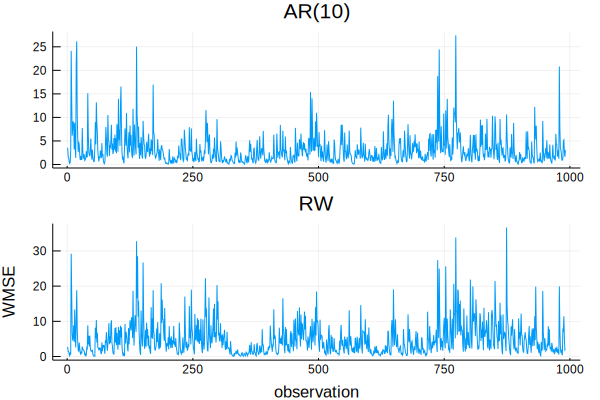

In [312]:
# Plotting
using Plots
pAR = plot(WMSEs, title="AR($ARorder)", label="")
pRW = plot(WMSEs_rw, xlabel="observation", ylabel="WMSE", title="RW", label="")
plot(pAR, pRW, layout=(2,1))

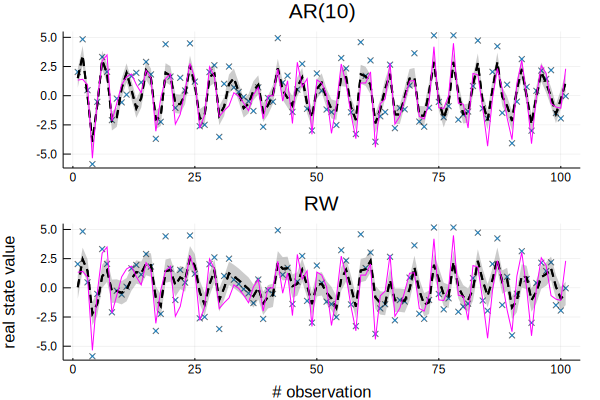

In [313]:
from = 500
upto = 600 # limit for building a graph 
scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in w_x[1:end]] # variances of estimated state
scatter(noise[from:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([m_x[from:upto], m_x[from:upto]], fillrange=[m_x[from:upto] -
      scale .* sqrt.(v_x[from:upto]), m_x[from:upto] +
      scale .* sqrt.(v_x[from:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(real[from:upto], color = :magenta, linewidth = 1.0, label="real state")
pRW = plot!(xlabel="# observation", ylabel="real state value", title="RW")


v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
scatter(noise[from:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([estimated[from:upto], estimated[from:upto]], fillrange=[estimated[from:upto] -
      scale .* sqrt.(v_x[from:upto]), estimated[from:upto] +
      scale .* sqrt.(v_x[from:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(real[from:upto], color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(title="AR($ARorder)", legend=false)

plot(pAR, pRW, layout=(2,1), legend=false)

In [314]:
sum(WMSEs)

3130.532319207646

In [315]:
sum(WMSEs_rw)

4886.13688946758